In [1]:
from pyrdf2vec.graphs import KG
import rdflib
import random 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from collections import Counter

In this notebook, we are investigating the robustness of RDF2Vec based on the prediction performance of the resulting embeddings. That is, we want to use the embeddings to predict an entity class. The underlying question in this document is:

Do the different embeddings lead to the same prediction?

To be precise, we use the embeddings to train a k-NN classifier for the type of the entity.

# 1 Data and Preprocessing
## 1.1 Get the entitites and corresponding classes

In [2]:
data = "aifb"
if data == "aifb":
    kg = KG(location="../data/aifbfixed_complete.n3", file_type="n3")
elif data == "bgs":
    kg = KG(location="../data/bgs.nt", file_type="nt")
elif data== "mutag":
    kg = KG(location="../data/mutag.xml", file_type="xml")

g = rdflib.Graph()
if data == "aifb":
    g.parse("../data/aifbfixed_complete.n3", format="n3")
elif data == "bgs":
    g.parse("../data/bgs.nt", format="nt")
elif data == "mutag":
    g.parse("../data/mutag.xml", format="xml")

q = g.query("""SELECT ?entity ?type
            WHERE {
              ?entity rdf:type ?type.
            }""")
entities = []
classes = []
for row in q:
    entities.append(row[0])
    classes.append(row[1])

In [3]:
set(classes)

{rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Article'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#AssistantProfessor'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Book'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#FullProfessor'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Graduate'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#InCollection'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#InProceedings'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Lecturer'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Manager'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Misc'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Organization'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Person'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#PhDStudent'),
 rdflib.term.URIRef('http://swrc.ontoware.org/ontology#Proceedings'),
 rdflib.term.URIRef('http://swrc.ontoware

## 1.2. Filtering

Some entities do not have a type. We preprocess data such that we only include entities with a type:
(Note, we will use the term *type* and *class* interchangably)

In [4]:
filtered_index = []
index = 0
for e in entities:
    if e in kg._entities:
        filtered_index.append(index)
    index += 1
    
entities_filt = [entities[i] for i in filtered_index]
classes_filt = [classes[i] for i in filtered_index]

entities = entities_filt

Each class is a string like "http://swrc.ontoware.org/ontology#TechnicalStaff". We do some preprocessing to obtain a more natural presentation (by deleting the leading characters).

In [9]:
def get_classes(data):
    classes = []
    for class_type in classes_filt:
        if data == "mutag":
            class_type = class_type.lstrip("http://dl-learner.org/carcinogenesis#")
            class_type = class_type.lstrip("www.w3.org/2002/07/owl#")
        elif data == "aifb":
            class_type = class_type.lstrip("http://swrc.ontoware.org/ontology#")
            class_type = class_type.lstrip("3.org/2002/07/owl#")
        classes.append(class_type)
    return np.array(classes)

Finally, each entity is one of the following set of classes:

In [10]:
print(Counter(get_classes(data)))

Counter({'Publication': 1222, 'Person': 1045, 'InProceedings': 687, 'TechnicalReport': 169, 'Article': 161, 'ResearchTopic': 146, 'InCollection': 87, 'Project': 78, 'PhDStudent': 65, 'Class': 55, 'Misc': 51, 'Proceedings': 49, 'ObjectProperty': 42, 'DatatypeProperty': 31, 'Organization': 28, 'Book': 23, 'Lecturer': 6, 'Undergraduate': 6, 'FullProfessor': 5, 'ResearchGroup': 5, 'AssistantProfessor': 3, 'TechnicalStaff': 3, 'Graduate': 2, 'Ontology': 1, 'Datatype': 1, 'Manager': 1})


The empirical distribution of the classes is far from being equally distribution. In the AIFB data set, the KG almost entirely consists of entities of the type *Publication*, *Person*, or *InProceedings*. 
To learn a proper prediction model, we decide to include only these classes.

In [13]:
def select_classes(data):
    if data == "aifb":
        return(["Publication", "Person", "InProceedings"])
    elif data == "mutag":
        return(["Hydrogen-3", "Bond-1", "Bond-7", "Carbon-22", "Carbon-10"])
    
def select_data(X, data):
    '''
    Returns a supervised data set with embeddings X and labels y for data which is in accordance 
    to the selected classes. The output can be used to train a prediction model. 
    
    Args:
        X: The embedding of size N x D
        data: aifb or mutag
    
    Returns:
        X: Rows of the embedding that have a label in the set of selected classes
        y: Label, which is in the set of selected classes
    '''
    classes = get_classes(data)
    selected_classes = select_classes(data) # get the most prominent classes
    indexes = []
    for j in range(len(classes)):
        if classes[j] in selected_classes:
            indexes.append(j)
    X = X[indexes]
    y = classes[indexes]
    return(X, y)

## 1.3. Import the embeddings

In [14]:
nlp_model = "skip-gram" # skip-gram or cbow
num_embeddings = 10
embeddings = []

dim_red = "tsne2d" # "pca2d", "pca3d", "tsne2d", or "tsne3d"

# read embeddings:
for iter in range(num_embeddings):
    embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/" + dim_red + "/embedding" + str(iter) + ".npy"))

# 2 Analyzing the Prediction Performance using the Embeddings
## 2.1 k-NN classifier performance of one embedding
Before comparing if all embeddings yield to the same predictions, we analyze the prediction performance of one embedding used for predicting the entity class.

In [15]:
X, y = select_data(embeddings[0], data)

### 2.1.1 A first glance at the data

In [16]:
for class_type in set(y):
    print(class_type)
    print(len(X[np.where(y==class_type)]))

Publication
1222
InProceedings
687
Person
1045


In [17]:
X_cp = X.copy()
scaler = StandardScaler()
X_cp_scaled = scaler.fit_transform(X_cp)

The 2D-Representation (using t-SNE dimension reduction) of the embedding:

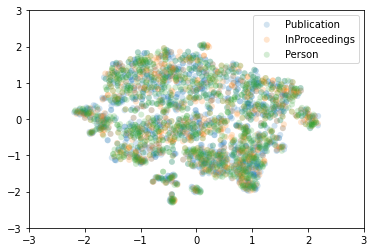

In [18]:
fig, ax = plt.subplots()
for class_type in set(y):
    index = np.where(y==class_type)
    ax.scatter(X_cp_scaled[index, 0], X_cp_scaled[index,1], label=class_type,
               alpha=0.2, edgecolors='none')
ax.legend()
ax.set_ylim([-3, 3])
ax.set_xlim([-3,3])
plt.show()

As we can see, the classes don't look well-seperable. K-NN is probably not working well. One could hypothesize 
1. either that the embeddings using RDF2Vec are too bad structured, 
2. or that we loose too much structure by appyling a 2D-Dimension reduction.

I think that the second hypothesis is more likely...

### 2.1.2 Train the model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

n_neighbors = 20
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [21]:
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
y_pred = clf.predict(X_test)

In [23]:
f'The accuracy is: {np.round(sum(y_pred == y_test)/len(y_pred), 2)} %'

'The accuracy is: 0.38 %'

Not surprisingly, (see the scatter plot above) the accuracy is pretty bad and slightly above randomly guessing, which would yield a accuracy of $1/3$. 

## 2.2 Similar Preditions?
We saw that the prediction performance isn't good. But are these prediciton at least similar across different embeddings? 

To be precise, we train 10 different k-NN classifiers each based on of the 10 embeddings, and compare if they lead to the same prediction. If so, this could be interpreted as some kind of robustness.

In [24]:
def compare_pred(data, dim_red, nlp_model):
    num_embeddings = 10
    embeddings = []

    # read embeddings:
    if dim_red=="":
        for iter in range(num_embeddings):
            embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/embedding" + str(iter) + ".npy"))
    else:
        for iter in range(num_embeddings):
            embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/" + dim_red + "/embedding" + str(iter) + ".npy"))
            
    # k-NN for each embedding    
    for j in range(num_embeddings):   
        X, y = select_data(embeddings[j], data)

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        if j==0:
            df_y = pd.DataFrame(data=y_test, columns=["truth"])
        
        
        n_neighbors = 20
        clf = neighbors.KNeighborsClassifier(n_neighbors)
        clf.fit(X_train, y_train)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        
        y_pred = clf.predict(X_test)
        # concatenate the columns
        df_y = pd.concat([df_y, pd.DataFrame(data=y_pred, columns=["Embedding" + str(j)])], axis=1)

    # calculate the pairwise accuracy
    pw_accuracy = np.zeros((10,10))
    for j in range(num_embeddings):
        for i in range(num_embeddings):
            acc = sum( df_y["Embedding" + str(j)] == df_y["Embedding" + str(i)]) / len(df_y)  
            pw_accuracy[i, j] = np.round(acc, 2)
    pw_results = pw_accuracy[np.triu_indices(num_embeddings, k=1)]
    print(f'Results for the {data} dataset using RDF2Vec via {nlp_model} and the dimension reduction technique {dim_red}.')
    print(f'The average pairwise accuracy is {np.round(np.mean(pw_results), 2)} with a variance between pairwise accuracies of {np.round(np.var(pw_results), 2)}.')       

### 2.2.1 CBOW:

In [25]:
compare_pred(data, "pca2d", "cbow")

Results for the aifb dataset using RDF2Vec via cbow and the dimension reduction technique pca2d.
The average pairwise accuracy is 0.48 with a variance between pairwise accuracies of 0.0.


In [26]:
compare_pred(data, "pca3d", "cbow")

Results for the aifb dataset using RDF2Vec via cbow and the dimension reduction technique pca3d.
The average pairwise accuracy is 0.51 with a variance between pairwise accuracies of 0.0.


In [27]:
compare_pred(data, "tsne2d", "cbow")

Results for the aifb dataset using RDF2Vec via cbow and the dimension reduction technique tsne2d.
The average pairwise accuracy is 0.53 with a variance between pairwise accuracies of 0.01.


In [28]:
compare_pred(data, "tsne3d", "cbow")

Results for the aifb dataset using RDF2Vec via cbow and the dimension reduction technique tsne3d.
The average pairwise accuracy is 0.5 with a variance between pairwise accuracies of 0.01.


In [29]:
# without dimension reduction: 
compare_pred(data, "", "cbow")

Results for the aifb dataset using RDF2Vec via cbow and the dimension reduction technique .
The average pairwise accuracy is 0.46 with a variance between pairwise accuracies of 0.02.


The last chunk investigates the performance in the case of no dimension reduction. Note, the embeddings are of dimensionality $D=100$.

### 2.2.2 skip-gram:

In [31]:
compare_pred(data, "pca2d", "skip-gram")

Results for the aifb dataset using RDF2Vec via skip-gram and the dimension reduction technique pca2d.
The average pairwise accuracy is 0.5 with a variance between pairwise accuracies of 0.0.


In [32]:
compare_pred(data, "pca3d", "skip-gram")

Results for the aifb dataset using RDF2Vec via skip-gram and the dimension reduction technique pca3d.
The average pairwise accuracy is 0.53 with a variance between pairwise accuracies of 0.01.


In [33]:
compare_pred(data, "tsne2d", "skip-gram")

Results for the aifb dataset using RDF2Vec via skip-gram and the dimension reduction technique tsne2d.
The average pairwise accuracy is 0.53 with a variance between pairwise accuracies of 0.01.


In [34]:
compare_pred(data, "tsne3d", "skip-gram")

Results for the aifb dataset using RDF2Vec via skip-gram and the dimension reduction technique tsne3d.
The average pairwise accuracy is 0.56 with a variance between pairwise accuracies of 0.01.


### 2.2.3 Summarize the results
We want to summarize all results and display them in a boxplot:

In [35]:
def summary(data):
    num_embeddings = 10
    dim_red_methods = ["pca2d", "pca3d", "tsne2d", "tsne3d"]
    nlp_models = ["sg", "cbow"]

    counter = 0
    results = np.zeros(2)
    for nlp_model in ("cbow", "skip-gram"):
        for dim_red in ("pca2d", "pca3d", "tsne2d", "tsne3d"):
            embeddings = []
            # read embeddings:
            if dim_red=="":
                for iter in range(num_embeddings):
                    embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/embedding" + str(iter) + ".npy"))
            else:
                for iter in range(num_embeddings):
                    embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/" + dim_red + "/embedding" + str(iter) + ".npy"))

            # k-NN for each embedding    
            for j in range(num_embeddings):   
                X, y = select_data(embeddings[j], data)

                X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                if j==0:
                    df_y = pd.DataFrame(data=y_test, columns=["truth"])


                n_neighbors = 20
                clf = neighbors.KNeighborsClassifier(n_neighbors)
                clf.fit(X_train, y_train)

                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)

                y_pred = clf.predict(X_test)
                # concatenate the columns
                df_y = pd.concat([df_y, pd.DataFrame(data=y_pred, columns=["Embedding" + str(j)])], axis=1)

            # calculate the pairwise accuracy
            accuracy = np.zeros(len(y_test))
            y_same = np.zeros(len(y_test))
            for i in range(num_embeddings - 1):
                for j in range(i + 1, num_embeddings):
                    y_same += (df_y["Embedding" + str(i)] == df_y["Embedding" + str(j)])
                    
            if counter==0:
                results = pd.DataFrame({"accuracy":y_same/(num_embeddings * (num_embeddings - 1)/2), "method":np.repeat(nlp_model, len(y_same)), "dim_red": np.repeat(dim_red, len(y_same))}, columns=("accuracy", "method", "dim_red") )
            else:
                results = results.append(pd.DataFrame({"accuracy":y_same/(num_embeddings * (num_embeddings - 1)/2), "method":np.repeat(nlp_model, len(y_same)), "dim_red": np.repeat(dim_red, len(y_same))}, columns=("accuracy", "method", "dim_red") ))
            counter += 1
            
    return(results)

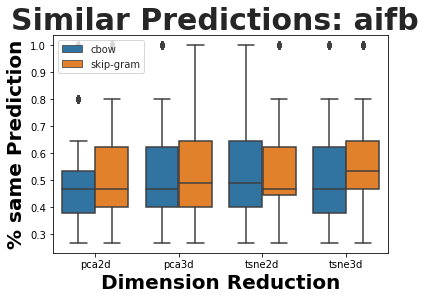

In [36]:
results = summary(data)

fig, ax = plt.subplots()
sns.set_style("white")
color = sns.color_palette("tab10")
ax = sns.boxplot(x="dim_red", y="accuracy", hue="method", data=results, palette="tab10")
#ax.set_title("Pairwise similarities: " + data, fonzsize=30)
ax.set_xlabel("Dimension Reduction", fontsize=20, weight="bold")
ax.set_ylabel("% same Prediction", fontsize=20, weight="bold")
fig.suptitle("Similar Predictions: " + data, fontsize=30, weight="bold")
plt.legend(loc='upper left')
fig.savefig("embeddings/" + data + "/boxplot_prediction.pdf")
plt.show()